# AIPI 590 - XAI | Assignment #02
### Interpreatble ML
### Rebecca Du (rrd17)



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW2/AIPI590_InterpretableML_Final.ipynb)


In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590" # Change to your repo name
git_path ='https://github.com/rrdu/AIPI-590.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'HW2'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'AIPI-590'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 2), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 1.30 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/AIPI-590/HW2
AIPI590_InterpretableML_Final.ipynb


## Overview

I was tasked with recommending interpretable ML models for a telecommunications company dealing with customer churn.

The dataset for this problem comes from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code).

The notebook is structured as follows:

1) **Exploratory Data Analysis and Check Assumptions**
    - 1.1) Exploratory Data Analysis
      - 1.1a) Loading Data
      - 1.1b) Missing Values, Data Types
      - 1.1c) Descriptive Statistics
      - 1.1d) Data Visualization
      - 1.1e) Churn Conversion, One-Hot Encoding
    - 1.2) Assumptions Overview
      - 1.2a) Linearity (Partial)
      - 1.2b) Homoscedasticity
      - 1.2c) No Multicollinearity
      - 1.2d) No Influential Outliers
2) **Linear Regression**
    - 2.1) Make Linear Regression Model
    - 2.2) Interpret Coefficients
    - 2.3) Check for Assumptions
      - 2.3a) Linearity
      - 2.3b) Independence
      - 2.3c) Homoscedasticity
      - 2.3d) Normality of Residuals
    - 2.4) Evaluate Performance
3) **Logistic Regression**
    - 3.1) Make Logistic Regression Model
    - 3.2) Interpret Coefficients
    - 3.3) Evaluate Performance
4) **Generalized Additive Models (GAM)**
    - 4.1) Make GAM Model
    - 4.2) Interpret Coefficients
    - 4.3) Evaluate Performance
5) **Model Comparison**
6) **Model Recommendation**



## 1) Exploratory Data Analysis and Check Assumptions

### 1.1) Exploratory Data Analysis

First, we conduct the following basic exploratory data analysis steps:

  - a) Loading Data
  - b) Missing Values, Data Types
  - c) Descriptive Statistics
  - d) Data Visualization
  - e) Churn Conversion, One-Hot Encoding

## Imports

In [2]:
!pip install pygam --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.1 MB/s eta 0:00:00


In [3]:
#Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.sparse as sps
import math

from google.colab import drive

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families.links import Log
from statsmodels.tools import add_constant
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, normal_ad
from pygam import LinearGAM, LogisticGAM, s, l
from pygam.terms import TermList
from numpy.linalg import inv

#### 1.1a) Load Data

In [4]:
#Mount Google Drive to access data
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/AIPI590/HW2/Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

#Check data
df.head()

Mounted at /content/drive


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


From this, we can see that each row represents a customer, with the columns containing data about the customer's traits in regards to the company.

#### 1.1b) Missing Values, Data Types, Changes/Drops

In [5]:
#Check if there are missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
#Check data type of features
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


From this, we can see that:
- **SeniorCitizen** is actually a categorical variable that has been mapped to numeric.
  - 0 represents 'No', 1 represents 'Yes'
  - So, we will map it back
- **TotalCharges** is actually a numeric value, so we convert it.
- **customerID** is arbitrary and does not hold importance as a feature so we can drop it



In [7]:
#Drop missings
df = df.dropna()

#Remap TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

#Drop missings
df = df.dropna()

#Remap SeniorCitizen
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})

#Drop customerID
df = df.drop(['customerID'], axis = 1)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Now, let's split up the numeric features from the categorical ones.

In [8]:
#Numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_cols.tolist()

numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [9]:
#Categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('Churn')

categorical_features = categorical_cols.tolist()

categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

#### 1.1c) Descriptive Statistics

Next, let's see the central tendency and dispersion measures for our numeric features.

In [10]:
#Descriptive statistics
print("\nDescriptive Statistic")
print("------------------------")
print("Central Tendency Measures")
print(df[numeric_cols].describe().loc[['mean', '50%']])
print("\nDispersion Measures")
print(df[numeric_cols].describe().loc[['std', 'min', 'max']])

print("\nDistribution Measures")
print("------------------------")
print(df[numeric_cols].skew())
print(df[numeric_cols].kurt())


Descriptive Statistic
------------------------
Central Tendency Measures
         tenure  MonthlyCharges  TotalCharges
mean  32.421786       64.798208   2283.300441
50%   29.000000       70.350000   1397.475000

Dispersion Measures
       tenure  MonthlyCharges  TotalCharges
std  24.54526       30.085974   2266.771362
min   1.00000       18.250000     18.800000
max  72.00000      118.750000   8684.800000

Distribution Measures
------------------------
tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64
tenure           -1.387823
MonthlyCharges   -1.256156
TotalCharges     -0.231799
dtype: float64


From the information, we can gather the following:
- **tenure**: customers stay an average of 32 months, but half stay fewer than 29 months.
- **MonthlyCharges**: the distribution is left-skewed due to the median being higher than the mean.
  - This indicates there are more customers paying high MonthlyCharges.
- **TotalCharges**: the distribution is right-skewed due to the high mean (compared to the median).
  - It seems that most customers don't pay a lot overall
  - This may be due to a few longtime customers that pay a lot and cause the mean to be high.

#### 1.1d) Data Visualization

Next, let's create some visualizations to better understando our data (specifically the categorical features)

<Axes: xlabel='Churn', ylabel='count'>

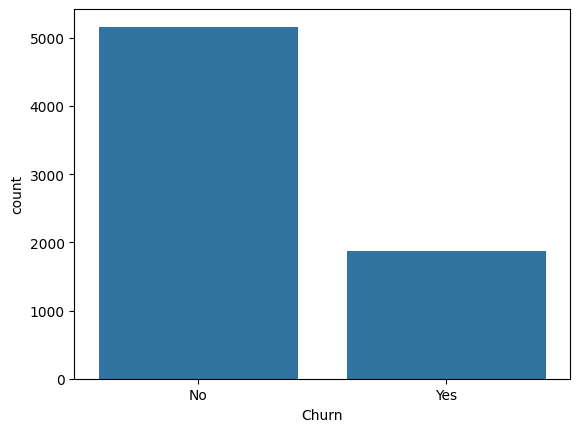

In [11]:
#First, see general distribution of churn
sns.countplot(x='Churn', data=df)

From this, we can see that the data is not equally distributed in regards to our target variable **churn**: we have a lot more data on non-churner customers than churners.

Now, let's see how the categorical features relate to churn.

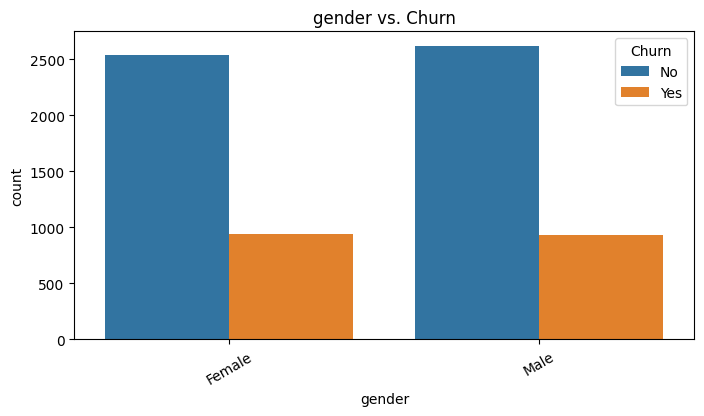

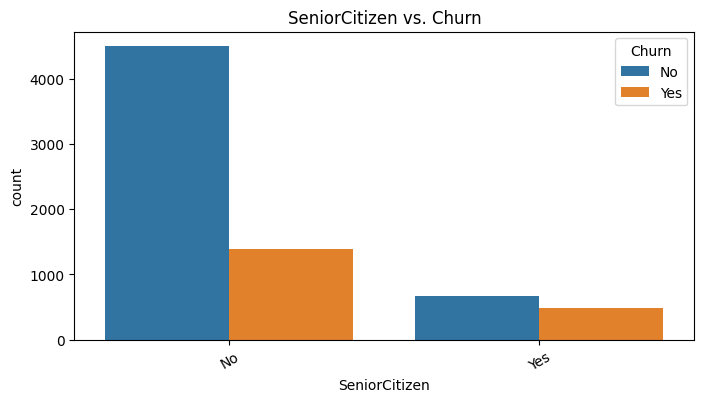

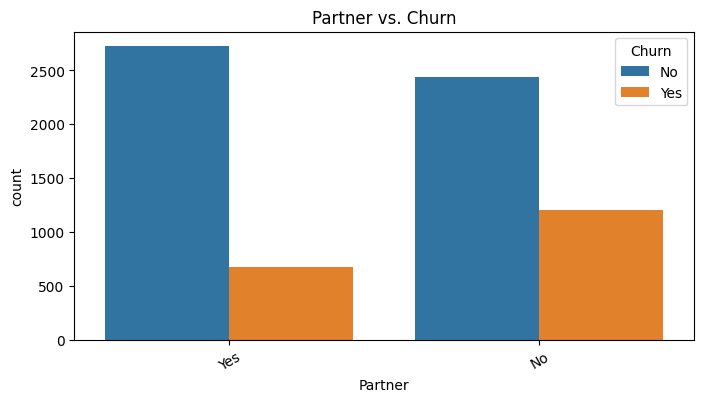

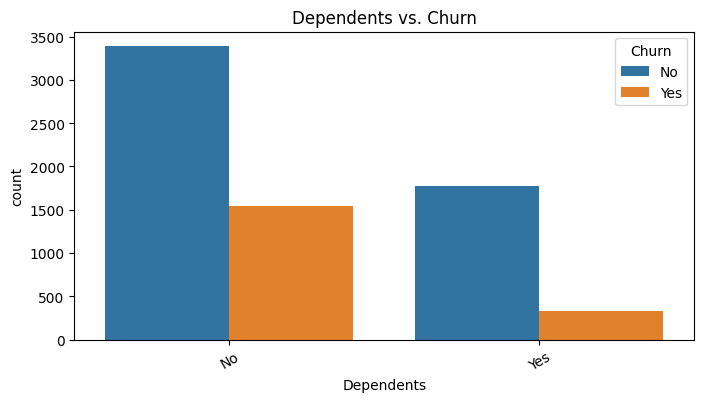

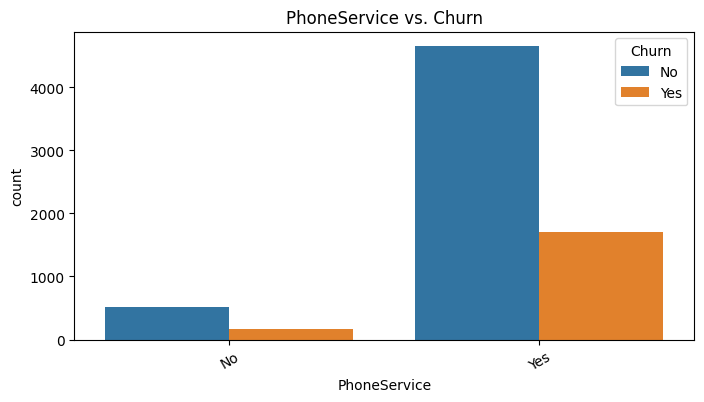

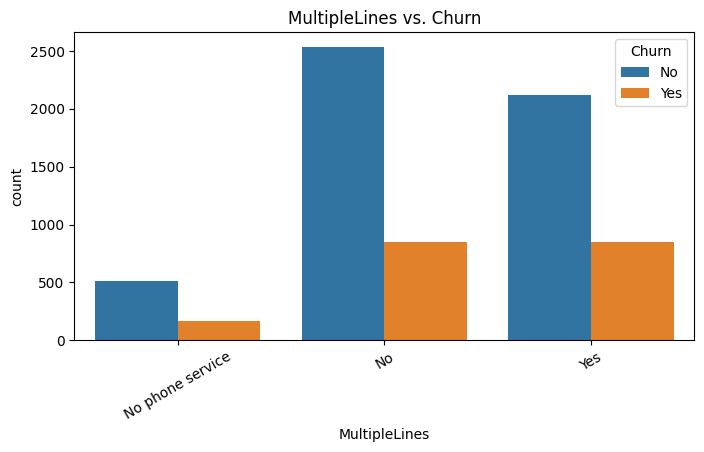

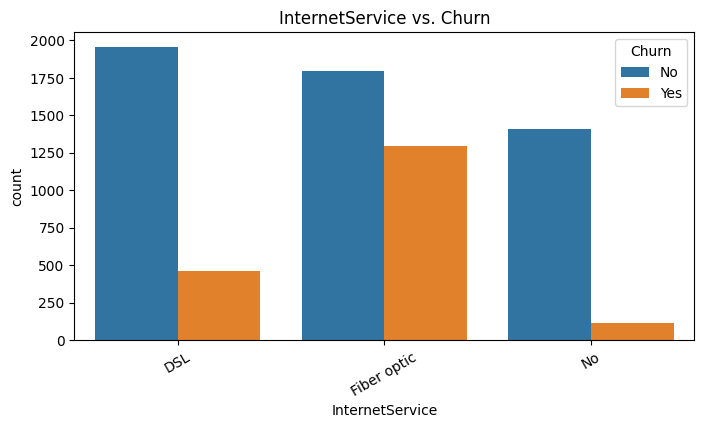

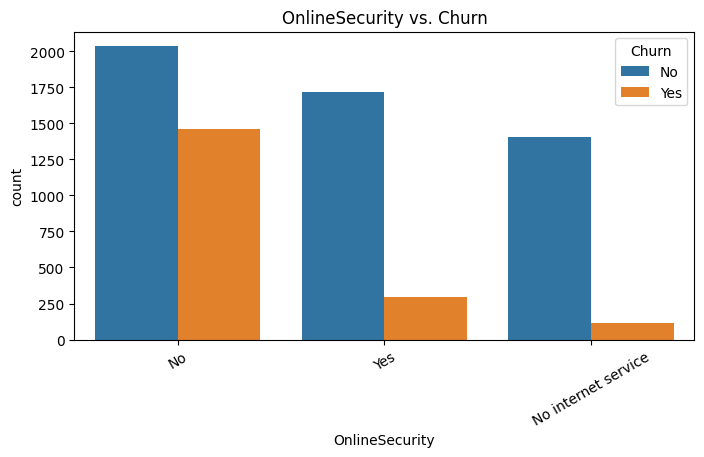

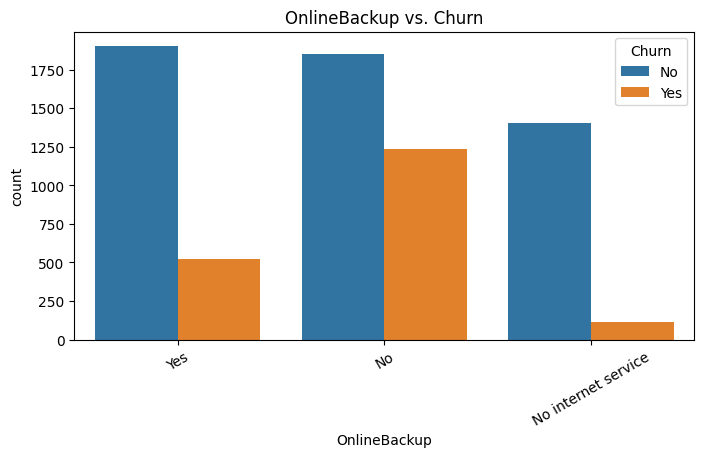

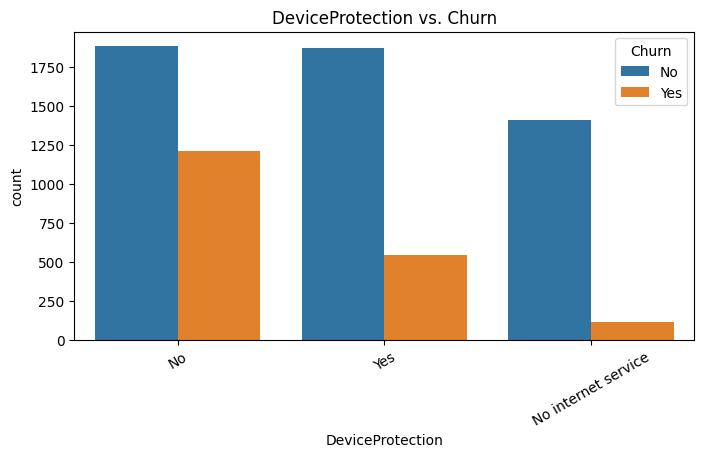

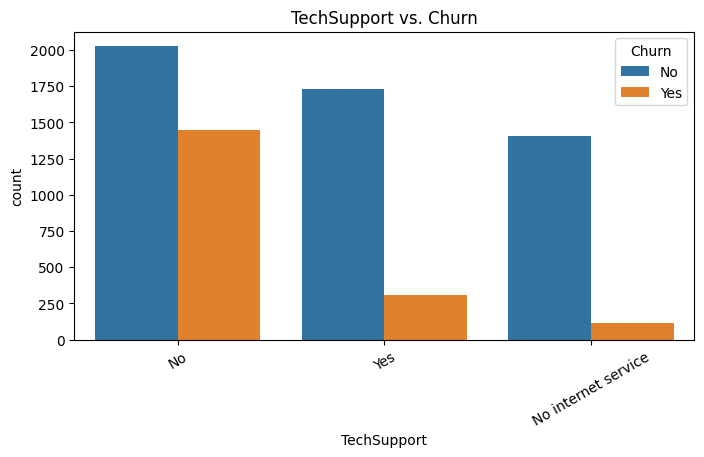

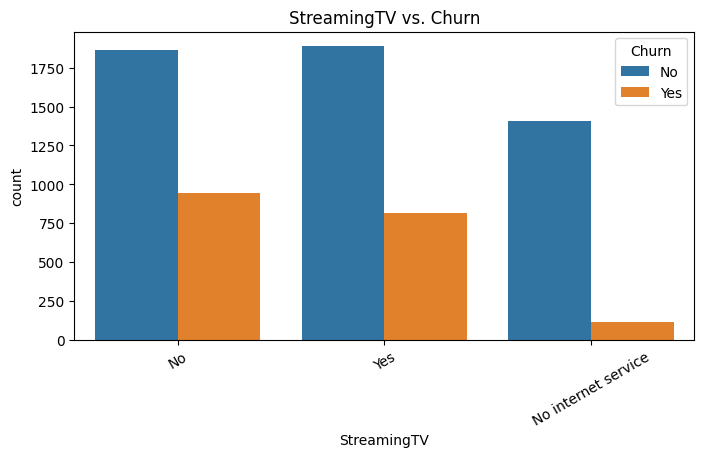

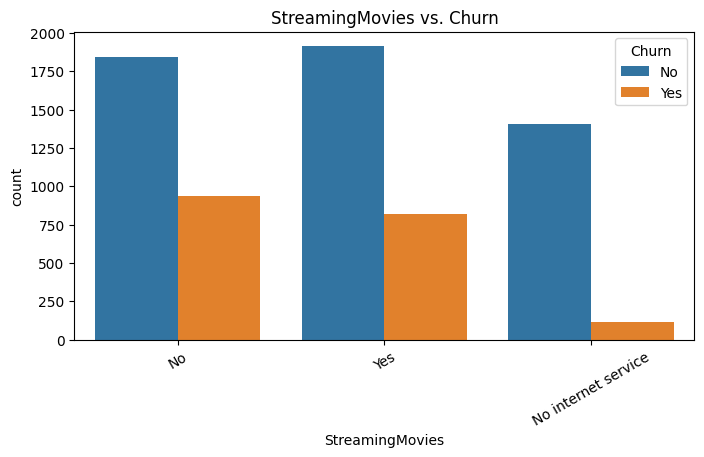

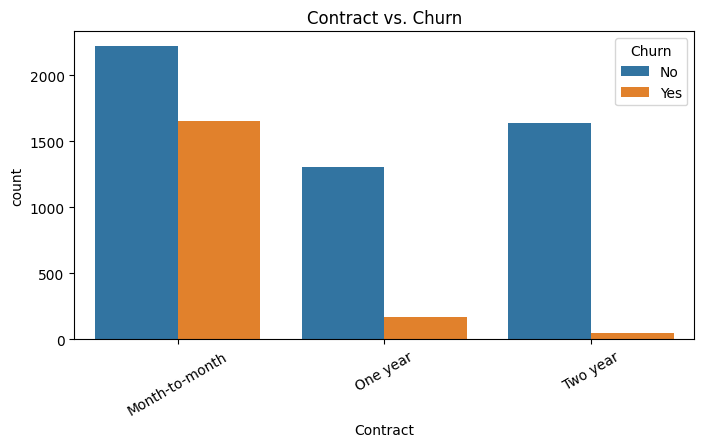

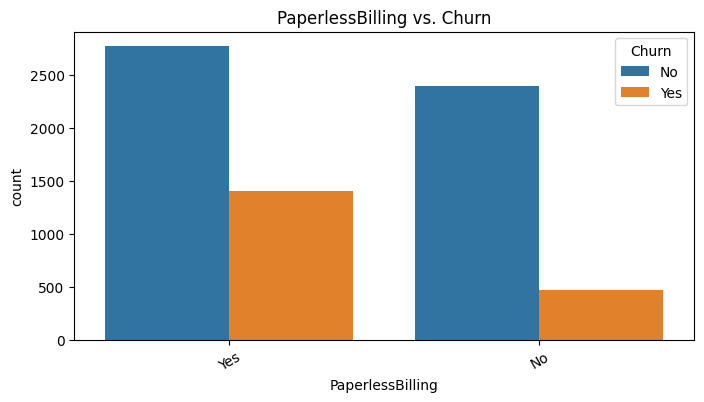

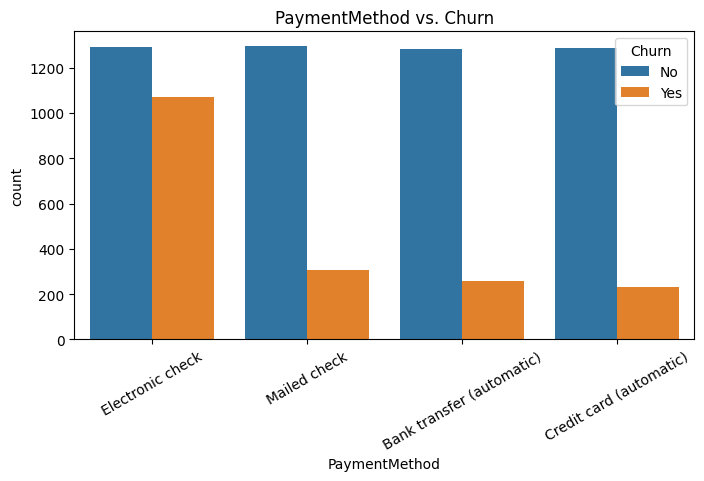

In [12]:
#Barplots of categorical features
for feature in categorical_features:
  plt.figure(figsize=(8,4))
  sns.countplot(x=feature, hue='Churn', data=df)
  plt.title(f'{feature} vs. Churn')
  plt.xticks(rotation=30)
  plt.show()

The bar plots tell us the following about how the categorical features relate to churn:
- **Gender**: there is no visible difference between the non-churners and churners of different genders, so this is likely not a good predictor.

- **SeniorCitizen**: senior citizens have a higher rate of churning compared to non-senior citizens, making age a potential risk factor for churn.

- **Partner**: customers with partners churn less often than those who are single.

- **Dependents**: customers with dependents churn significantly less than those without.

- **PhoneService**: there are only a few
customers without Phone Service.
  - Customers who do have phone service tend to not churn (maybe because they have paid for this addition and are thus committed to the company).

- **MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport**: customers *without* these features tend to churn more often.
  - All of these features appear to be add-ons to a base plan, so customers that have them are likely satisfied enough with the company to pay more.

- **StreamingTV, StreamingMovies**: there is little difference between customers that have/don't have these features.

- **Contract**: this is our strongest predictor so far due to the disparity between the churn rates of the different plans.
  - *Month-to-month*: customers have very high churn rate
  - *Yearly*: customers have significantly lower churn rates
  - Perhaps customers who pay monthly do not invest as much money at once and so feel freer to churn

- **PaperlessBilling**: customers who have paperless billing churn more often

- **PaymentMethod**: customers who pay via electronic check churn the most


Of these categorical features, the standout predictors of churn are:
- **ContractType**: monthly (high churn) vs. yearly (low churn)
- **PaymentMethod**: electronic check (high churn)

Next, let's make a correlation matrix/heatmap for the numeric features to see how they relate to each other.

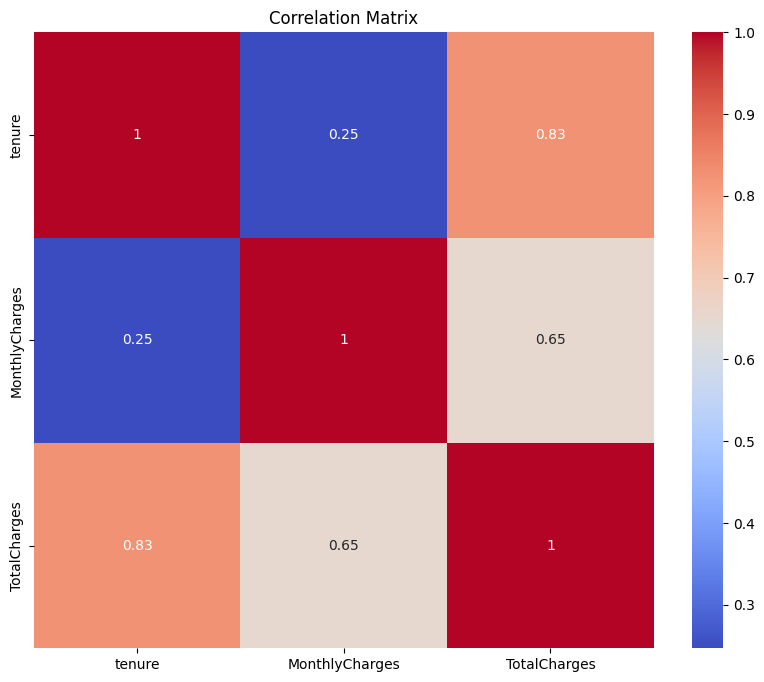

In [13]:
#Correlation matrix
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

The correlation matrix tells us the following:

- **tenure and TotalCharges**: strong positive correlation (0.85)
  - This makes sense intuitively because customers who stay a long time will naturally pay more
- **MonthlyCharges vs. TotalCharges**: moderate positive correlation (0.65)
  - This also makes sense because customers with high monthly charges will also have higher total charges
- **tenure vs. MonthlyCharges**: weak positive correlation (0.25)
  - Some long-tenure customers will stil have low monthly payments while some short-tenure customers have higher monthly payments

Something we should watch out for is the strong positive correlations present. This may be an early indicator of multicollinearity (i.e. that the features can be computed from each other).


#### 1.1e) Churn Conversion, One-Hot Encoding

To make sure that our features are ready for modeling, we will do the following:
- Map **churn**'s values:
  - No Churn = 0
  - Yes Churn = 1
- One-hot encode the categorical features

In [14]:
#Make an encoded version of the df
df_encoded = pd.get_dummies(
    df,
    columns=categorical_features,
    drop_first=True,
    dtype=int
)

#Map Churn to numeric values
df_encoded['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

#Display the first few rows of the encoded dataframe
display(df_encoded.head())

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


## 1.2) Assumptions Overview

The following table summarizes the assumptions that each model makes, as well as the appropriate tests that will be conducted.

Since linear regression has the most assumptions, we will test all of them. We will not repeat overlaps for the remaining two models.

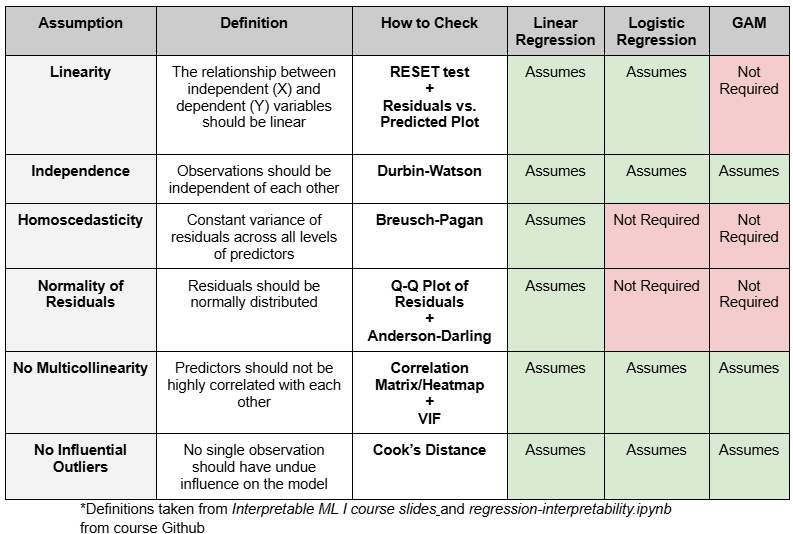

Of these assumptions, the only ones we can test right now are:
- a) **Linearity** (partially)
- b) **Homoscedasticity**
- c) **No Multicollinearity**.
- d) **No Influential Outliers**

The rest of the assumptions rely on residuals (the difference between the model's predicted value and the ground-truth) and fitted values. Since we haven't made a model yet, we can't test them yet.

*Note: There is no scikit-learn function to test RESET, Breusch-Pagan, and Cook's Distance so we create a statsmodel linear regression model statsmodel.OLS here for now.

### 1.2a) Linearity (Partial)

We can perform the **RESET Test**. The test checks if adding nonlinear transformations of the predictors will improve the model.

If it does, then the original model is likely missing crucial nonlinear terms.

In [15]:
#Define X, y
X_sm = df_encoded.drop(columns=['Churn'])
y_sm = df_encoded['Churn']

#Add a constant to the training data
X_sm_const = sm.add_constant(X_sm, has_constant='add')

#Fit an OLS model
sm_linear_model = sm.OLS(y_sm, X_sm_const).fit()

#Do RESET test
reset_test_result = linear_reset(sm_linear_model, use_f=True)

print("\nRESET Test Results:")
print("---------------------")
print(reset_test_result)


RESET Test Results:
---------------------
<F test: F=106.72978175128489, p=2.1875245544545388e-46, df_denom=7.01e+03, df_num=2>


The results tell us the following:
- **F = $106.72$**: adding a nonlinear term explains the data better than the original linear model
- **p = $2.46 \times 10^{-46}$**: there is a no chance that the linear model is correct

Basically, this tells us that **the assumption of linearity is violated** and that the linear regression model is insufficient to capture the variation in the data.


#### 1.2b) Homoscedasticity

To check for homoscedasiticy, we will perform:
1. **Breusch-Pagan Test**: checks if the residuals have constant variance

In [16]:
#Calculate residual
#Start of code generated with GPT-5 at 9:45 PM on 9.14.2025
sm_residual = sm_linear_model.resid
exog = sm_linear_model.model.exog

sm_lm_stat, sm_lm_p, sm_lm_f, sm_lm_fp = het_breuschpagan(sm_residual, exog) #End of generated code
print("\nBreusch–Pagan Test:")
print(f"LM stat = {sm_lm_stat:.3f}, p = {sm_lm_p:.3g}")
print(f"F  stat = {sm_lm_f:.3f}, p = {sm_lm_fp:.3g}")


Breusch–Pagan Test:
LM stat = 1370.480, p = 1.49e-269
F  stat = 73.757, p = 6.47e-308


For the Breusch-Pagan test, our null hypothesis is that the residuals have constant variance (i.e. that homoscedasticity is upheld).

However, the large LM and F statistics coupled with a nearly 0 p value indicate that the null hypothesis is overwhelmingly rejected.

In short, this means that **the assumption of homoscedasticity is violated**.

#### 1.2c) No Multicollinearity

To test for multicollinearity, we will do two tests:
1. **Correlation Matrix/Heatmap** (see Section 1.1d)
    - We have made and analyzed this already.
    - To reiterate, **tenure, MonthlyCharges, and TotalCharges** demonstrated strong positive correlation, meaning they are likely multicollinear.
2. **Variance Inflation Factor (VIF)**:
    - We will perform this test now, which shows *how* correlated the numeric predictors are.



In [17]:
#Select only the numeric columns
numeric_df = df_encoded[numeric_features]

#Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i)
                          for i in range(numeric_df.shape[1])]

print("\nVIF (Numeric Features)")
print(vif_data)


VIF (Numeric Features)
          Feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181


The general rule for understanding VIF values is that:
  - VIF = 1: no correlation with other features
  - VIF = 1-5: moderate correlation, usually ok
  - VIF > 5 or 10: multicollinearity is present

From this, we can see that all the numeric features demonstrate high multicollinearity.

**Thus, the assumption of no multicollinearity is violated.**

#### 1.2d) No Influential Outliers

To assess whether there are influential outliers, we will perform the following:
1. **Cook's Distance**

   Cook's Distance  p-value
0     2.128585e-04      1.0
1     7.223179e-07      1.0
2     3.286226e-04      1.0
3     1.420107e-08      1.0
4     4.918994e-05      1.0


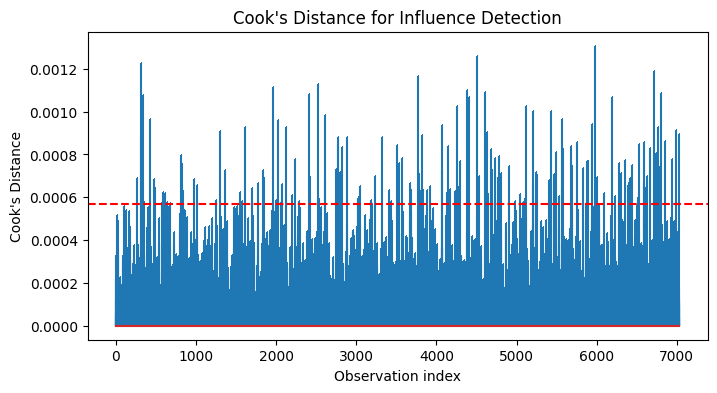

In [18]:
#Cook's Distance
influence = sm_linear_model.get_influence()
cooks_d, pvals = influence.cooks_distance

cooks_df = pd.DataFrame({
    "Cook's Distance": cooks_d,
    "p-value": pvals
})

print(cooks_df.head())

#Plot
plt.figure(figsize=(8,4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4/len(cooks_d), color="red", linestyle="--")  #Cutoff
plt.xlabel("Observation index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Influence Detection")
plt.show()

The red dotted line represents the threshold over which points are considered influential outliers.

From the plot and the numeric results, we can see that Cook's Distance is quite small. This means that **the assumption of no influential outliers is upheld**.

## 2) Linear Regression

In **linear regression**, the coefficients directly show the impact of each feature on the target variable.*


*Taken from regression-interpretability.ipynb from course Github

In [19]:
#Define X,y
#Reminder: df_encoded has combined one-hot categorical + numeric features!
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [20]:
#Evaluate linear model
y_pred = linear_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#Create a DataFrame for coefficients
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': linear_model.coef_})

print("\nLinear Regression Coefficients:")
display(coefficients_df.sort_values(by='Coefficient', ascending=False))

Mean Squared Error: 0.14593552097785373
R-squared: 0.252214079317581

Linear Regression Coefficients:


,Feature,Coefficient
10,InternetService_Fiber optic,0.273538
23,StreamingMovies_Yes,0.095261
21,StreamingTV_Yes,0.092138
9,MultipleLines_Yes,0.068537
28,PaymentMethod_Electronic check,0.062299
4,SeniorCitizen_Yes,0.054641
26,PaperlessBilling_Yes,0.035931
17,DeviceProtection_Yes,0.021537
7,PhoneService_Yes,0.021362
15,OnlineBackup_Yes,0.007571


### 2.2) Interpret Coefficients

The coefficients determine the relative impact of each feature on churn probability. The closer the value is to either 1 or -1 indicates the strength of the impact.
- **Positive coefficients** mean the feature is associated with a high probability of churn
  - I.e. customer with this feature is likely to churn
- **Negative coefficients** mean the feature is associated with a low probability of churn
  - I.e. customer with this feature is unlikely to churn

Let's start with the notable positive coefficients:
- **InternetService_Fiber optic = 0.27**: this shows that customers who have fiber optic are likely to churn.
- **StreamingMovies_Yes = 0.095, StreamingTV_Yes = 0.092**: customers that stream movies and TV are slightly likely to churn, perhaps due to the compounded cost of additional features.
- **MultipleLines_Yes = 0.069**: customer with multiple lines are slightly more likely to churn than those with a single line.
- **PaymentMethod_Electronic check = 0.062**: customers paying by electronic check are more likely to churn.
- **SeniorCitizen_Yes = 0.055**: seniors churn more than non-seniors
- **PaperlessBilling_Yes = 0.036**: customers with paperless billing churn more than those who don't have it.

Now onto the negative coefficients:
- **Contract_One year = -0.117, Contract_Two year = -0.075**: customers with longer contracts are slightly less likely to churn.
- **OnlineSecurity_Yes = -0.037, TechSupport_Yes = -0.038**: the presence of security and tech support lowers churn likelihood.
- **Dependents_Yes = -0.028, Partner_Yes = -0.007**: customers with families churn less
- **InternetService_No = -0.033**: customers with no internet service churn less.

Now for the numeric features:
- **tenure = -0.0019, totalCharges = -0.000045, MonthlyCharges = -0.0037**: due to collinearity from the correlation matrix/VIF, these are likely unstable, but the slight negative indicates high tenure/bills reduce churn slightly.


### 2.3) Check for Assumptions

Now that we have our model, we can check for the following assumptions:
- a) Linearity (Residuals)
- b) Independence
- c) Normality of Residuals
- d) No Influential Outliers

#### 2.3a) Linearity (Residuals)

To check for linearity, we will do the following:

1. **RESET test**: see Section 1.2a
2. **Residuals vs. Predicted Plot**: we will plot to see the difference between what the linear regression model predicted and what the ground truth is.

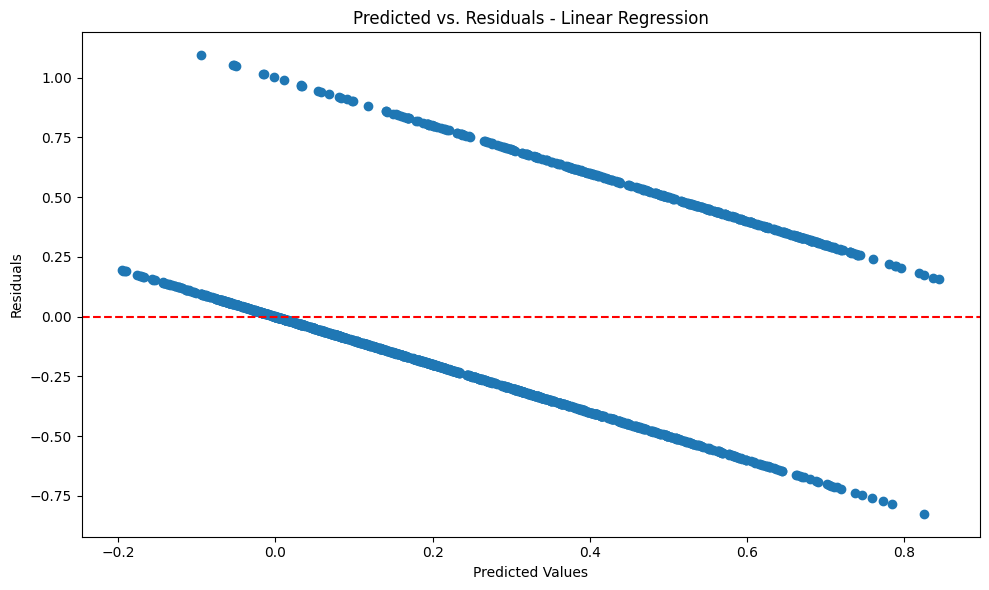

In [21]:
#Calculate residuals
residuals = y_test - y_pred

#Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Predicted vs. Residuals - Linear Regression')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

The plot shows that the points are not randomly scattered, indicating that **the assumption regarding linearity is violated.**

This can be explained by the fact that churn is a binary outcome, which linear regression is not suited to capturing (it works better for continuous data).

#### 2.3b) Independence

To test the assumption of independence, we perform the following:
1. **Durbin-Watson test**

In [22]:
#Durbin-Watson
dw = durbin_watson(residuals)
print('Durbin-Watson statistic: ', dw)

Durbin-Watson statistic:  2.0014820981110075


For the Durbin-Watson test, values around 2 indicate no autocorrelation (i.e. **the assumption of independence is upheld**)

#### 2.3c) Normality of Residuals

To check for the assumption of normality of residuals, we will perform the following:
1. Make a **Q-Q Plot of Residuals**
2. **Anderson-Darling Test**

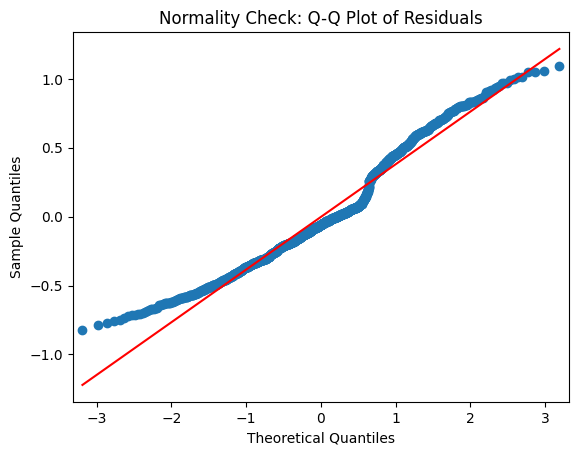

In [23]:
#Q-Q Plot of Residuals
sm.qqplot(residuals, line='s')
plt.title('Normality Check: Q-Q Plot of Residuals')
plt.show()

In [24]:
#Anderson-Darling
ad_stat, ad_p = normal_ad(residuals)
print(f"Anderson–Darling stat = {ad_stat:.3f}, p = {ad_p:.3g}")

Anderson–Darling stat = 19.102, p = 0


In the plot, the red line represents the line of perfect normality. The blue dotted line represents the residuals from our model.

We use the result of the Anderson-Darling test to inform our understanding more. The p value is 0, which is less than the 0.05 threshold for which the assumption of residual normality is upheld.

**Thus, the assumption of normality of residuals is violated.**

### 2.4) Evaluate Performance

To evaluate how well our linear regression model performed, let's plot it against the actual test data points.

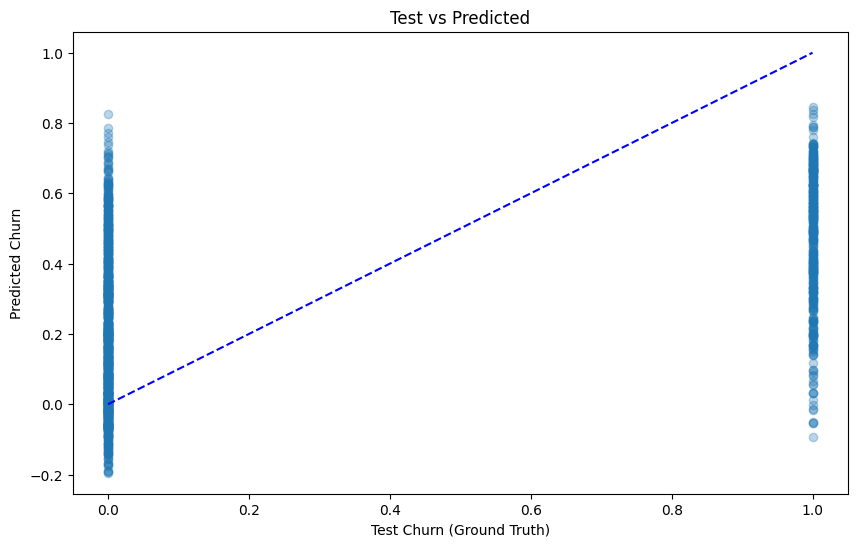

In [25]:
#Plot test vs. predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,1], [0,1], color='blue', linestyle='--')
plt.xlabel("Test Churn (Ground Truth)")
plt.ylabel("Predicted Churn")
plt.title("Test vs Predicted")
plt.show()


From the initial evaluation, we see that **MSE = 0.14** and **$R^{2}$ = 0.25**, meaning that the model explains only 31% of the variance in churn.

This demonstrates that the **linear regression** is not a great fit for predicting churn and is struggling to capture what is likely a nonlinear relationship.

Furthermore, through the assumption checks, we see that the assumptions of **linearity, homoscedasticity, multicollinearity, and normality of residuals** are not upheld, demonstrating that linear regression is not suitable for modeling the data.

This is all confirmed in the plot above, which shows that linear regression did not model the spread of the data appropriately.

It appears that linear regression, while interpretable, does not perform well on the actual task of predicting churn.

## 3) Logistic Regression

Logistic regression is essentially a linear model for the log odds

## 3.1) Make Logistic Regression Model

In [26]:
#Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [27]:
#Evaluate logistic regression
y_pred_logistic = logistic_model.predict(X_test_scaled)

#Get evaluation metrics
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_cm = confusion_matrix(y_test, y_pred_logistic)
logistic_cr = classification_report(y_test, y_pred_logistic)
logistic_roc_auc = roc_auc_score(y_test, y_pred_logistic)

#Print evaluation metrics
print("Logistic Regression Metrics:")
print(f"Logistic Regression Accuracy: {logistic_accuracy}")
print(f"Logistic Regression Confusion Matrix:\n{logistic_cm}")
print(f"Logistic Regression Classification Report:\n{logistic_cr}")
print(f"Logistic Regression ROC AUC: {logistic_roc_auc}")

Logistic Regression Metrics:
Logistic Regression Accuracy: 0.7874911158493249
Logistic Regression Confusion Matrix:
[[915 118]
 [181 193]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Logistic Regression ROC AUC: 0.7009061919232185


In [28]:
#Create a DataFrame for coefficients
coefficients_df_logistic = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logistic_model.coef_[0]})

#Calculate odds ratios
coefficients_df_logistic['Odds Ratio'] = np.exp(coefficients_df_logistic['Coefficient'])

print("\nLogistic Regression Coefficients and Odds Ratios:")
display(coefficients_df_logistic.sort_values(by='Odds Ratio', ascending=False))


Logistic Regression Coefficients and Odds Ratios:


,Feature,Coefficient,Odds Ratio
2,TotalCharges,0.694885,2.003478
10,InternetService_Fiber optic,0.650749,1.916976
23,StreamingMovies_Yes,0.222440,1.249121
21,StreamingTV_Yes,0.212963,1.237338
9,MultipleLines_Yes,0.160546,1.174151
26,PaperlessBilling_Yes,0.134580,1.144056
28,PaymentMethod_Electronic check,0.123558,1.131516
4,SeniorCitizen_Yes,0.094976,1.099632
17,DeviceProtection_Yes,0.040129,1.040945
8,MultipleLines_No phone service,0.029736,1.030182


### 3.2) Interpret Coefficients

The OR (odds ratio) are an exponentiated version of the coefficients. It represents how likely customers with a certain features are likely to churn.
- OR > 1 means that the feature increases the odds of churn
- OR < 1 decreases the odds of churn

Based on the OR, the following coefficients noticeably **reduce** the likelihood of churn:

- **Contract_Two year (OR = 0.567):** Customers with two-year contracts are **43% less likely** to churn than those on month-to-month contracts.  
- **Tenure (OR = 0.236):** Customers with longer tenure are about **76% less likely** to churn, reflecting loyalty and satisfaction over time.  
- **Contract_One year (OR = 0.730):** Customers with one-year contracts are **27% less likely** to churn than those on month-to-month plans.  
- **OnlineSecurity_Yes (OR = 0.856), TechSupport_Yes (OR = 0.866):** Customers with online security and technical support services are less likely to churn.  
- **Dependents_Yes (OR = 0.905):** Customers with dependents are **~10% less likely** to churn.  
- **PhoneService_Yes (OR = 0.971):** Having phone service slightly lowers churn likelihood.  
- **MonthlyCharges (OR = 0.531):** Higher monthly charges are associated with lower churn odds, perhaps due to bundled services or longer contracts.  
- **PaymentMethod_Credit card (automatic) (OR = 0.944) and PaymentMethod_Mailed check (OR = 0.973):** Customers using these payment methods are less likely to churn compared to electronic check.  
- **InternetService_No and various “No internet service” categories (all OR ≈ 0.929):** Customers without internet service are less likely to churn, likely because they use fewer add-on services.  

Based on the OR, the following coefficients noticeably **increase** the likelihood of churn:
- **TotalCharges (OR = 2.003):** Customers with higher total charges are **twice as likely** to churn, suggesting long-term billing buildup contributes to eventual departure.  
- **InternetService_Fiber optic (OR = 1.917):** Fiber optic customers are almost **twice as likely** to churn, making this a strong risk factor.  
- **StreamingMovies_Yes (OR = 1.249), StreamingTV_Yes (OR = 1.237):** Customers who stream movies and TV are **25–24% more likely** to churn, possibly due to unmet entertainment expectations.  
- **MultipleLines_Yes (OR = 1.174):** Customers with multiple lines have about **17% higher odds** of churning.  
- **PaperlessBilling_Yes (OR = 1.144):** Paperless billing is linked to a **14% increase** in churn likelihood.  
- **PaymentMethod_Electronic check (OR = 1.132):** Customers paying with electronic check have ~13% higher odds of churning.  
- **SeniorCitizen_Yes (OR = 1.100):** Senior citizens are about **10% more likely** to churn.  
- **DeviceProtection_Yes (OR = 1.041):** Device protection has a small positive association with churn.  

### 3.3) Evaluate Performance

- **Accuracy = 0.787**: the Logistic Regression model correctly predicted ~79% of customers.  
- **ROC AUC = 0.701**: the model shows moderate ability to discern between churn and non-churn customers.  
- **Confusion Matrix**:  
  - *True Negatives (non-churn predicted correctly)*: **915**  
  - *False Positives (churn predicted incorrectly)*: **118**  
  - *False Negatives (non-churn predicted incorrectly)*: **181**  
  - *True Positives (churn predicted correctly)*: **193**  
  - This demonstrates the model correctly identifies many non-churners, but has difficulty capturing churners, with a relatively high number of false negatives.  

- **Classification Report**:  
  - **Class 0 (No Churn):**  
    - _Precision_: **0.83**  
    - _Recall_: **0.89**  
    - _F1-score_: **0.86**  
  - **Class 1 (Churn):**  
    - _Precision_: **0.62**  
    - _Recall_: **0.52**  
    - _F1-score_: **0.56**  
  - This indicates that the model performs well in predicting non-churners, with strong precision and recall.  
  - However, it struggles with churners, correctly identifying only ~52% of them and misclassifying many as non-churners.  
  - The imbalance in the dataset (more non-churners than churners) likely contributes to this issue, as the model has fewer churn examples to learn from.  

## 4) Generalized Additive Model (GAM)

Generalized Additive Model (GAM) assumes the outcome can be modeled as a sum of functions of each feature. It does so using B-splines that make it good for modeling nonlinear relationships.*

*From generalized-models-interpretability.ipynb notebook in course Github

## 4.1) Make GAM

In [29]:
#Find numeric columns in X
feature_names = X.columns.tolist()
num_cols_in_X = [c for c in numeric_features if c in feature_names]
num_idx = [feature_names.index(c) for c in num_cols_in_X]
all_idx = list(range(len(feature_names)))
bin_idx = [j for j in all_idx if j not in num_idx]

#Scale only numeric columns
X_train_gam = X_train.copy().astype(float).values
X_test_gam  = X_test.copy().astype(float).values
scaler = StandardScaler()
if num_idx:
    X_train_gam[:, num_idx] = scaler.fit_transform(X_train_gam[:, num_idx])
    X_test_gam[:,  num_idx] = scaler.transform(X_test_gam[:,  num_idx])

y_train_gam = y_train.values.astype(int)
y_test_gam  = y_test.values.astype(int)

#Build terms
term_list = [s(j) if j in num_idx else l(j) for j in range(X_train_gam.shape[1])]
terms_expr = TermList(*term_list)

#Build GAM
gam = LogisticGAM(terms=terms_expr).fit(X_train_gam, y_train_gam)

In [30]:
#Evaluate GAM
y_pred_gam = gam.predict(X_test_gam)
y_pred_gam_proba = gam.predict_proba(X_test_gam)

#Get evaluation metrics
acc_gam = accuracy_score(y_test_gam, y_pred_gam)
cm_gam = confusion_matrix(y_test_gam, y_pred_gam)
cr_gam = classification_report(y_test_gam, y_pred_gam)
roc_auc_gam = roc_auc_score(y_test_gam, y_pred_gam_proba)

#Print evaluation metrics
print("GAM Metrics:")
print(f"GAM Accuracy: {acc_gam}")
print(f"GAM Confusion Matrix:\n{cm_gam}")
print(f"GAM Classification Report:\n{cr_gam}")
print(f"GAM ROC AUC: {roc_auc_gam}")

GAM Metrics:
GAM Accuracy: 0.7967306325515281
GAM Confusion Matrix:
[[932 101]
 [185 189]]
GAM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

GAM ROC AUC: 0.8384617773889456


### 4.2) Interpret Coefficients

From the statistics above, we can see the following:
- **Accuracy = 0.79**: This shows that GAM was more accurate than both linear and logistic regression.
- **ROC AUC = 0.83**: This demonstrates that GAM was able to separate customers that churn and customers that don't churn quite well.
- **Confusion Matrix**:
  - *True Negatives (non-churn predicted correctly)*: 932
  - *False Positives (churn predicted incorrectly)*: 101
  - *False Negatives (non-churn predicted incorrectly)*: 185
  - *True Positives (churn predicted correctly)*: 189
  - This further confirms that GAM was able to distinguish well between churn and non-churn.
  - Interestingly, whereas logistic regression had more False Positives, GAM struggled with False Negatives.


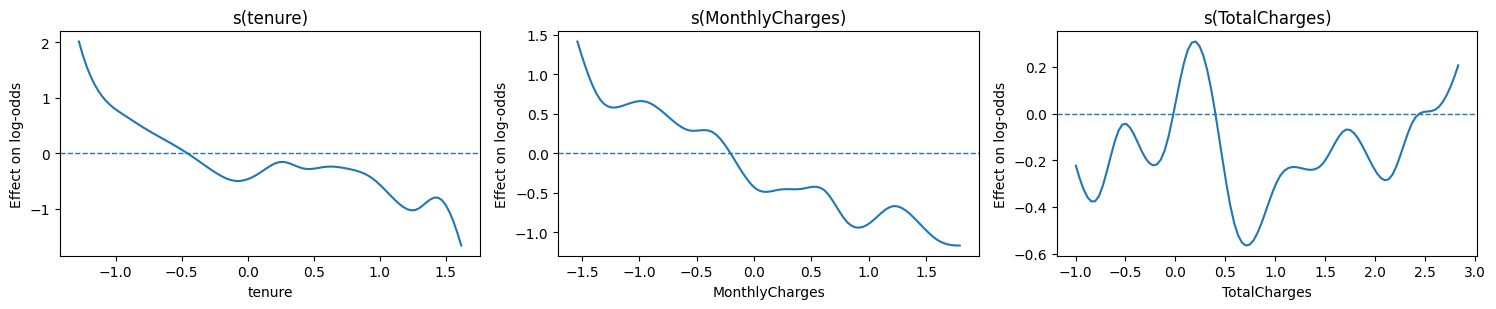

In [31]:
#Plot partial dependency
numeric_terms = [j for j in range(len(feature_names)) if j in num_idx]

n = len(numeric_terms)
if n:
    ncols, nrows = 3, math.ceil(n/3)
    plt.figure(figsize=(5*ncols, 3.2*nrows))

    for k, term_idx in enumerate(numeric_terms, start=1):
        ax = plt.subplot(nrows, ncols, k)

        # grid that varies only this term
        XX = gam.generate_X_grid(term=term_idx)
        pdp = gam.partial_dependence(term=term_idx, X=XX).ravel()

        xvals = XX[:, term_idx]
        ax.plot(xvals, pdp)
        ax.axhline(0, ls="--", lw=1)
        ax.set_title(f"s({feature_names[term_idx]})")
        ax.set_xlabel(feature_names[term_idx])
        ax.set_ylabel("Effect on log-odds")

    plt.tight_layout()
    plt.show()

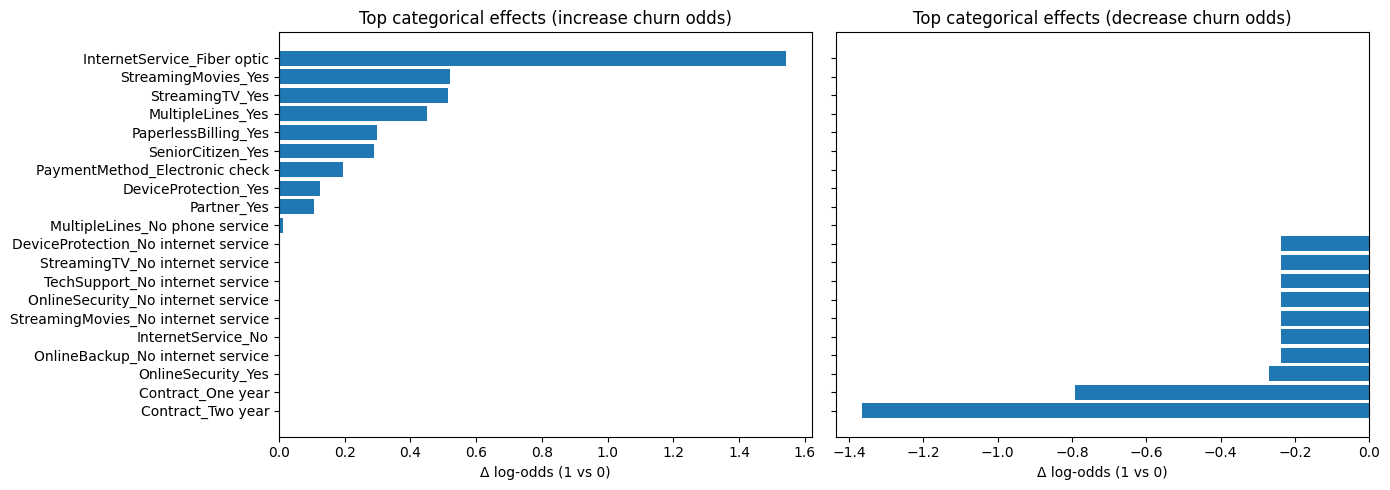

In [32]:
plot_terms = [(t_idx, t) for t_idx, t in enumerate(gam.terms) if not t.isintercept]

# Terms whose feature index is NOT in numeric list → dummies
cat_term_pairs = [(t_idx, t.feature) for t_idx, t in plot_terms if t.feature not in num_idx]

rows = []
for term_idx, feat_idx in cat_term_pairs:
    XX = gam.generate_X_grid(term=term_idx)        # varies only this dummy
    pdp = gam.partial_dependence(term=term_idx, X=XX).ravel()

    zz = pd.DataFrame({"x": XX[:, feat_idx], "pdp": pdp})
    eff0 = zz.loc[zz["x"] == 0, "pdp"].mean()
    eff1 = zz.loc[zz["x"] == 1, "pdp"].mean()

    rows.append({
        "feature": feature_names[feat_idx],
        "effect@0": eff0,
        "effect@1": eff1,
        "delta(1-0)": eff1 - eff0,   # ≈ log-odds change when dummy flips 0→1
    })

effects = pd.DataFrame(rows).sort_values("delta(1-0)", ascending=False)

# Plot top movers
top_pos = effects.head(10)
top_neg = effects.tail(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes[0].barh(top_pos["feature"], top_pos["delta(1-0)"])
axes[0].set_title("Top categorical effects (increase churn odds)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Δ log-odds (1 vs 0)")

axes[1].barh(top_neg["feature"], top_neg["delta(1-0)"])
axes[1].set_title("Top categorical effects (decrease churn odds)")
axes[1].set_xlabel("Δ log-odds (1 vs 0)")

plt.tight_layout()
plt.show()

### 4.3) Evaluate Performance

1. **Numeric Features (Partial Dependence)**
The GAM smooth plots show how each numeric feature influences the log-odds of churn:

    - **Tenure**: customers with longer tenure are less likely to churn, which intuitively makes sense and follows the results we have seen from linear and logistic regression as well.
      - The drop at the beginning suggests that new customers have the highest risk of churning, whereas long-term customers are more loyal.   

    - **MonthlyCharges**: customers with very low monthly charges show high churn risk, whereas middling charges are associated with reduced churn.
      - Again, this intuitively makes sense and can reflect customers that bundles together other add-ons and thus want to stay with the company longer.

    - **TotalCharges**: the effect is highly varied
      - At low **TotalCharges**, there is a lower churn risk because this likely represents new customers who haven't invested much in the company yet.
      - At middling **TotalCharges**, the curve has oscillations, indicating that some groups of customers have a temporary increase in churn risk.
      - At high **TotalCharges** there are slightly positive churn odds, indicating that even long-term customers may eventually churn.

2. **Categorical Features**: The categorical effect plots highlight the most important binary features:

- **Features that Increase Churn Odds**:  
  - **MultipleLines_Yes**: Having multiple phone lines strongly increases churn risk.  
  - **Streaming services** (e.g., *StreamingMovies_Yes*, *StreamingTV_Yes*): Streaming customers are more likely to churn, possibly due to higher expectations or alternative providers.  
  - **SeniorCitizen_Yes**: Senior citizens show slightly higher churn risk.  
  - **PaymentMethod_Electronic check**: Customers paying via electronic check are more likely to churn.

- **Features that Decrease Churn Odds**:  
  - **Contract_One year** and **Contract_Two year**: Longer contracts strongly reduce churn odds, with two-year contracts being the most protective.  
  - **OnlineSecurity_Yes**, **TechSupport_Yes**, **OnlineBackup_Yes**, and **DeviceProtection_Yes**: Customers with added support/security features are less likely to churn, likely due to higher satisfaction.  
  - **No Internet Service** categories (e.g., *InternetService_No*): Customers without internet service are less prone to churn, perhaps because they use fewer optional services.

### 4.3) Evaluate Model

From the initial results, we can see that GAM outperformed linear and logistic regression significantly, reaching the highest accuracy of **79.67%**, with a ROC AUC of 0.83. This is to be expected because GAMs are designed to model nonlinear relationships and are thus able to fit the data better than the other two models.

## 5) Model Comparison

The following table compares the strengths and weaknesses of the 3 models, as well as their performance and interpretability.

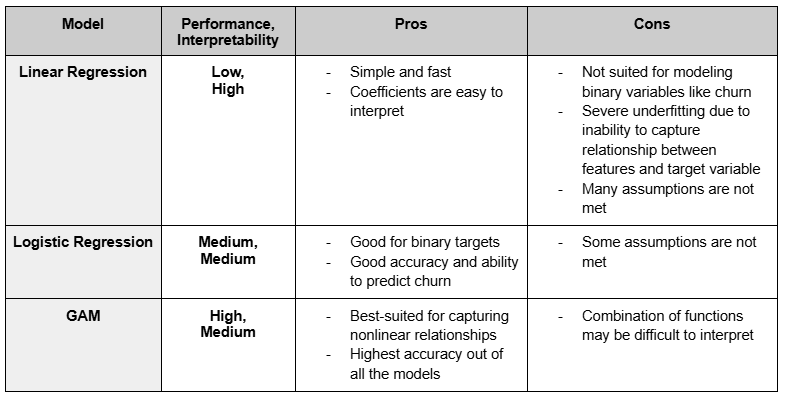

Overall, the best-performing model was **GAM** because it reached the highest accuracy (**81.6%** compared to Linear Regression's **31%** and Logistic Regression's **75%**)

One trend that stood out was that while the models were able to predict non-churners with high accuracy, they struggled when predicting individuals who *would* churn. This can be attributed to the skew in data (there was more data about non-churning customers than curning customers), hence why the model predictions were not as accurate.

## 6) Model Recommendation

The model recommendation I would give the company is to use **Generalized Additive Model (GAM)**. This is because GAM proved itself to be the best-performing model on the dataset. GAM's ability to capture nonlinear relationships exceeds that of logistic regression, providing more insight into potential customer behavior. Additionally, the visuals of each feature aid a bit with interpretability.

The main drawback of GAM is that the model is slightly more difficult to explain than logistic regression. If this is a major concern, then my second recommendation would be logistic regression because it is able to capture the relationship of the features to churn better than linear regression.